# 1. Data Preparation

## 1.1 Import and Clean Data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# Import libary
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import data
hsxraw = pd.read_csv('/content/gdrive/MyDrive/[DATA-NCKH]/CafeF.SolieuGD.Upto27012023/CafeF.HSX.Upto27.01.2023.csv')
hnxraw = pd.read_csv('/content/gdrive/MyDrive/[DATA-NCKH]/CafeF.SolieuGD.Upto27012023/CafeF.HNX.Upto27.01.2023.csv')
VNIndex_raw = pd.read_csv('/content/gdrive/MyDrive/[DATA-NCKH]/CafeF.Index.Upto27012023/CafeF.INDEX.Upto27.01.2023.csv')
famaraw4 = pd.read_stata('/content/gdrive/MyDrive/[DATA-NCKH]/Carhat4factor.dta')

In [ ]:
# Adjust columns'name
hsx_price = hsxraw.iloc[:,[0,1,5,6]]
hnx_price = hnxraw.iloc[:,[0,1,5,6]]
VNIndex = VNIndex_raw.iloc[:,[0,1,5,6]]
hsx_price.rename(columns = {'<Ticker>': 'Ticker', '<DTYYYYMMDD>': 'Date', '<Close>' : 'ClosePrice', '<Volume>': 'Volume'}, inplace = True)
hnx_price.rename(columns = {'<Ticker>': 'Ticker', '<DTYYYYMMDD>': 'Date', '<Close>' : 'ClosePrice', '<Volume>': 'Volume'}, inplace = True)
VNIndex.rename(columns = {'<Ticker>': 'Ticker', '<DTYYYYMMDD>': 'Date', '<Close>' : 'ClosePrice', '<Volume>': 'Volume'}, inplace = True)
VNIndex = VNIndex[VNIndex['Ticker']=='VNINDEX'].drop(['Ticker'], axis = 1)
fama4data = famaraw4.rename(columns = {'newdate': 'Date'})

# Correct Date Format
hsx_price['Date'] = pd.to_datetime(hsx_price['Date'], format = '%Y%m%d')
hnx_price['Date'] = pd.to_datetime(hnx_price['Date'], format = '%Y%m%d')
VNIndex['Date'] = pd.to_datetime(VNIndex['Date'], format = '%Y%m%d')

# Drop CW
hsx_price = hsx_price[hsx_price['Ticker'].apply(lambda x: len(x)) < 4]
hnx_price = hsx_price[hsx_price['Ticker'].apply(lambda x: len(x)) < 4]

# Sort Data
hsx_price.sort_values(by = ['Ticker', 'Date'], inplace = True)
hnx_price.sort_values(by = ['Ticker', 'Date'], inplace = True)
VNIndex.sort_values(by = ['Date'], inplace = True)


<ipython-input-28-5615f8997b1c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hsx_price.rename(columns = {'<Ticker>': 'Ticker', '<DTYYYYMMDD>': 'Date', '<Close>' : 'ClosePrice', '<Volume>': 'Volume'}, inplace = True)
<ipython-input-28-5615f8997b1c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hnx_price.rename(columns = {'<Ticker>': 'Ticker', '<DTYYYYMMDD>': 'Date', '<Close>' : 'ClosePrice', '<Volume>': 'Volume'}, inplace = True)
<ipython-input-28-5615f8997b1c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

## 1.2 Chuẩn bị dữ liệu cho mô hình

In [ ]:
# Create Dataframe
kll = hsx_price.groupby('Ticker').apply(lambda x: x['ClosePrice'].shift(1)).to_frame().reset_index().rename(columns = {'level_1': 'index'})
hsx_ret = pd.merge(hsx_price.reset_index(), kll, on = ['index', 'Ticker']).drop('index', axis = 1).dropna()
hsx_ret['daily_return'] = (hsx_ret['ClosePrice_x']/hsx_ret['ClosePrice_y']) - 1
hsx_ret.drop(['ClosePrice_x', 'ClosePrice_y'], axis = 1, inplace = True)
price_final = hsx_ret[hsx_ret['Ticker'] != 'VNAll-INDEX']


df_daily_returns_VNIndex = VNIndex.set_index('Date')['ClosePrice'].pct_change().to_frame().iloc[1:]
df_daily_returns_VNIndex.rename(columns = {'ClosePrice': 'Rm'}, inplace = True)


reg_price = price_final.sort_values(by = ['Date'])
reg_price = reg_price[abs(reg_price['daily_return'])<= 0.07]

result = pd.merge(reg_price, df_daily_returns_VNIndex, on=["Date"])
result[(result['Date']>='2008-08-18')&(result['Date']<='2013-01-15')] = \
                                      result[((result['Date']>='2008-08-18')&(result['Date']<='2013-01-15'))&(abs(result['daily_return'])<=0.05)]

In [ ]:
result

,Ticker,Date,Volume,daily_return,Rm
0,SAM,2000-07-31,10000.0,0.011736,0.015500
1,REE,2000-07-31,300.0,0.018773,0.015500
2,SAM,2000-08-02,200.0,0.017472,0.018021
3,REE,2000-08-02,100.0,0.018355,0.018021
4,SAM,2000-08-04,1900.0,0.017125,0.017605
...,...,...,...,...,...
985062,AAA,2023-01-27,3118200.0,0.026350,0.008140
985063,ITD,2023-01-27,48200.0,0.057377,0.008140
985064,NAF,2023-01-27,163400.0,0.009259,0.008140
985065,DCL,2023-01-27,35200.0,0.000000,0.008140


In [ ]:
result_export = result[(result.Date<'2018-01-01')&(result.Date>='2008-08-18')].sort_values(['Ticker', 'Date']).reset_index(drop=True).drop('Volume', axis = 1)[['Ticker', 'Date', 'daily_return']]

In [ ]:
result_export

,Ticker,Date,daily_return
0,AAA,2016-11-28,-0.016721
1,AAA,2016-11-29,0.000000
2,AAA,2016-11-30,0.000000
3,AAA,2016-12-01,-0.040818
4,AAA,2016-12-02,0.000000
...,...,...,...
501370,VTO,2017-12-25,0.069935
501371,VTO,2017-12-26,-0.001148
501372,VTO,2017-12-27,0.016068
501373,VTO,2017-12-28,-0.011290


In [ ]:
lll = result.groupby('Date').apply(lambda x: x['daily_return'].mean()).to_frame()
lll.rename(columns = {0: 'Rm'}, inplace = True)
result_eq = pd.merge(lll, reg_price, on = ['Date'])

result_eq[(result_eq['Date']>='2008-08-18')&(result_eq['Date']<='2013-01-15')] = \
                                      result_eq[((result_eq['Date']>='2008-08-18')&(result_eq['Date']<='2013-01-15'))&(abs(result_eq['daily_return'])<=0.05)]

result_eq

,Date,Rm,Ticker,Volume,daily_return
0,2000-07-31,0.015254,SAM,10000.0,0.011736
1,2000-07-31,0.015254,REE,300.0,0.018773
2,2000-08-02,0.017913,SAM,200.0,0.017472
3,2000-08-02,0.017913,REE,100.0,0.018355
4,2000-08-04,0.017610,SAM,1900.0,0.017125
...,...,...,...,...,...
985062,2023-01-27,0.011166,AAA,3118200.0,0.026350
985063,2023-01-27,0.011166,ITD,48200.0,0.057377
985064,2023-01-27,0.011166,NAF,163400.0,0.009259
985065,2023-01-27,0.011166,DCL,35200.0,0.000000


In [ ]:
result_eq_use = result_eq[(result_eq.Date<'2018-01-01')&(result_eq.Date>='2008-08-18')].sort_values(['Ticker', 'Date']).reset_index(drop=True).drop('Volume', axis = 1)

In [ ]:
result_eq_use

,Date,Rm,Ticker,daily_return
0,2016-11-28,-0.012193,AAA,-0.016721
1,2016-11-29,-0.006457,AAA,0.000000
2,2016-11-30,0.004369,AAA,0.000000
3,2016-12-01,0.000478,AAA,-0.040818
4,2016-12-02,-0.001826,AAA,0.000000
...,...,...,...,...
501370,2017-12-25,-0.002779,VTO,0.069935
501371,2017-12-26,0.002883,VTO,-0.001148
501372,2017-12-27,0.001010,VTO,0.016068
501373,2017-12-28,0.002225,VTO,-0.011290


In [ ]:
from statistics import stdev

a = result.groupby(by = 'Date').apply(lambda x: (abs((x['daily_return'] - x['Rm'])).mean())).to_frame().rename(columns = {0: 'CSAD'})
reg_table = pd.merge(df_daily_returns_VNIndex, a, on=["Date"])
reg_table.reset_index(inplace = True)
reg_table['Rm_ab'] = abs(reg_table['Rm'])
reg_table['Rm_sq'] = reg_table['Rm']**2


c = result_eq.groupby(by = 'Date').apply(lambda x: (abs((x['daily_return'] - x['Rm'])).mean())).to_frame().rename(columns = {0: 'CSAD'})
reg_table_eq = pd.merge(lll, c, on=["Date"])
reg_table_eq.reset_index(inplace = True)
reg_table_eq['Rm_ab'] = abs(reg_table_eq['Rm'])
reg_table_eq['Rm_sq'] = reg_table_eq['Rm']**2

In [ ]:
reg_table[(reg_table['Date']>='2008-08-18')&(reg_table['Date']<'2018-01-01')].reset_index(drop=True)

,Date,Rm,CSAD,Rm_ab,Rm_sq
0,2008-08-18,0.039085,0.015367,0.039085,0.001528
1,2008-08-19,0.006850,0.037518,0.006850,0.000047
2,2008-08-20,-0.005982,0.035799,0.005982,0.000036
3,2008-08-21,0.034437,0.018044,0.034437,0.001186
4,2008-08-22,0.001901,0.033475,0.001901,0.000004
...,...,...,...,...,...
2336,2017-12-25,0.006290,0.020415,0.006290,0.000040
2337,2017-12-26,0.007951,0.020374,0.007951,0.000063
2338,2017-12-27,0.002619,0.015716,0.002619,0.000007
2339,2017-12-28,0.008529,0.016755,0.008529,0.000073


In [ ]:
reg_table_export = reg_table[(reg_table['Date']>='2008-08-18')&(reg_table['Date']<'2018-01-01')].reset_index(drop=True)[['Date', 'CSAD', 'Rm']]

In [ ]:
reg_table_eq_export = reg_table_eq[(reg_table_eq['Date']>='2008-08-18')&(reg_table_eq['Date']<'2018-01-01')].reset_index(drop=True)[['Date', 'CSAD', 'Rm']]

In [ ]:
reg_table_eq[(reg_table_eq['Date']>='2008-08-18')&(reg_table_eq['Date']<'2018-01-01')].reset_index(drop=True)

,Date,Rm,CSAD,Rm_ab,Rm_sq
0,2008-08-18,0.035191,0.017208,0.035191,0.001238
1,2008-08-19,-0.004758,0.035770,0.004758,0.000023
2,2008-08-20,-0.010666,0.035057,0.010666,0.000114
3,2008-08-21,0.034849,0.017835,0.034849,0.001214
4,2008-08-22,0.009565,0.032960,0.009565,0.000091
...,...,...,...,...,...
2336,2017-12-25,-0.002779,0.017902,0.002779,0.000008
2337,2017-12-26,0.002883,0.019244,0.002883,0.000008
2338,2017-12-27,0.001010,0.015381,0.001010,0.000001
2339,2017-12-28,0.002225,0.015215,0.002225,0.000005


In [ ]:
reg_table_use = reg_table[(reg_table['Date']>='2008-08-18')&(reg_table['Date']<'2018-01-01')]
reg_table_use_eq = reg_table_eq[(reg_table_eq['Date']>='2008-08-18')&(reg_table_eq['Date']<='2018-01-01')]
reg_table_use_2008 = reg_table[(reg_table['Date']>='2007-06-01')&(reg_table['Date']<='2009-01-01')]

## 1.3 Chart creation

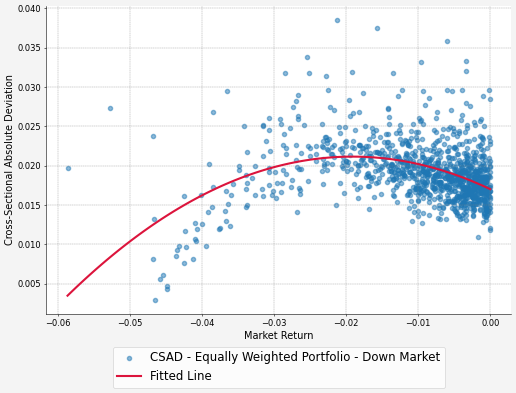

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.scatter(reg_table_use[reg_table_use['Rm']<=0]['Rm'], reg_table_use[reg_table_use['Rm']<=0]['CSAD'], color='#1f77b4', alpha=0.5, linewidth=2, label='CSAD - Equally Weighted Portfolio - Down Market')

# Add labels and title
ax.set_xlabel('Market Return', fontsize=14)
ax.set_ylabel('Cross-Sectional Absolute Deviation', fontsize=14)

# Fit a quadratic regression model to the data
coeffs = np.polyfit(reg_table_use[reg_table_use['Rm']<=0]['Rm'], reg_table_use[reg_table_use['Rm']<=0]['CSAD'], 2)
quad_fit = np.poly1d(coeffs)


# Add the quadratic regression line to the plot
x_range = np.linspace(reg_table_use[reg_table_use['Rm']<=0]['Rm'].min(), reg_table_use[reg_table_use['Rm']<=0]['Rm'].max(), 100)
ax.plot(x_range, quad_fit(x_range), color='crimson', linewidth=3, label='Fitted Line')

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.26), fontsize=17)

# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/CSAD_Rm_Down.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

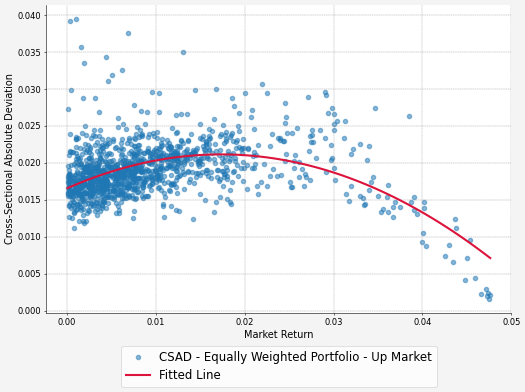

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.scatter(reg_table_use[reg_table_use['Rm']>0]['Rm'], reg_table_use[reg_table_use['Rm']>0]['CSAD'], color='#1f77b4', alpha=0.5, linewidth=2, label='CSAD - Equally Weighted Portfolio - Up Market')

# Add labels and title
ax.set_xlabel('Market Return', fontsize=14)
ax.set_ylabel('Cross-Sectional Absolute Deviation', fontsize=14)

# Fit a quadratic regression model to the data
coeffs = np.polyfit(reg_table_use[reg_table_use['Rm']>0]['Rm'], reg_table_use[reg_table_use['Rm']>0]['CSAD'], 2)
quad_fit = np.poly1d(coeffs)


# Add the quadratic regression line to the plot
x_range = np.linspace(reg_table_use[reg_table_use['Rm']>0]['Rm'].min(), reg_table_use[reg_table_use['Rm']>0]['Rm'].max(), 100)
ax.plot(x_range, quad_fit(x_range), color='crimson', linewidth=3, label='Fitted Line')

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/CSAD_Rm_Up.png', dpi=300, bbox_inches='tight')

# Add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.26), fontsize=17)

# Show the plot
plt.show()

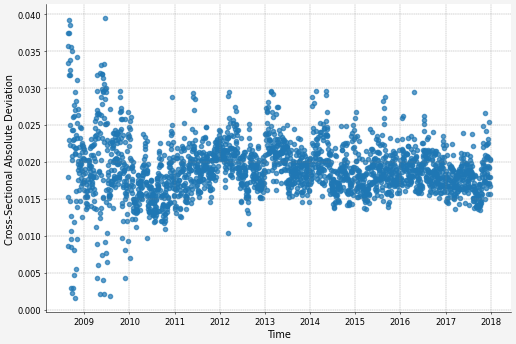

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.scatter(reg_table_use['Date'], reg_table_use['CSAD'], color='#1f77b4', linewidth=2, alpha = 0.7, label='CSAD - Equally Weighted Portfolio')

# Add labels and title
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Cross-Sectional Absolute Deviation', fontsize=14)

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/CSAD_Date.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

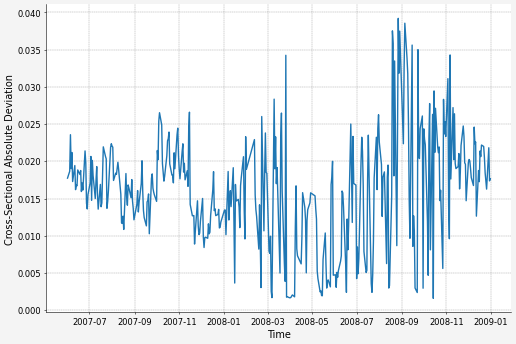

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.plot(reg_table_use_2008['Date'], reg_table_use_2008['CSAD'], color='#1f77b4', linewidth=2, label='CSAD - Equally Weighted Portfolio')

# Add labels and title
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Cross-Sectional Absolute Deviation', fontsize=14)

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/CSAD_For_DATA_part.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

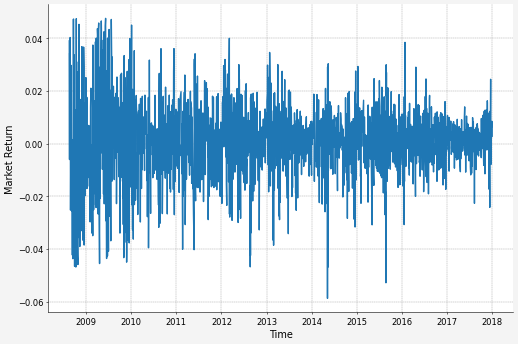

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.plot(reg_table_use['Date'], reg_table_use['Rm'], color='#1f77b4', linewidth=2, label='Market return')

# Add labels and title
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Market Return', fontsize=14)

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)



# Show the plot
plt.show()

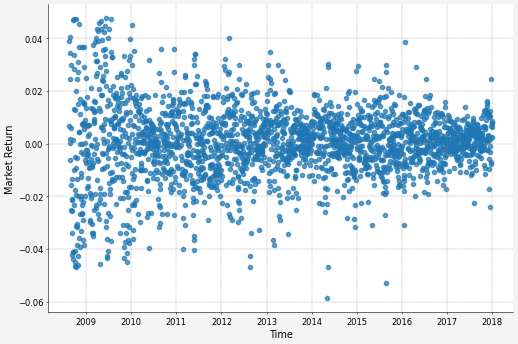

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.scatter(reg_table_use['Date'], reg_table_use['Rm'], color='#1f77b4', alpha = 0.7, linewidth=2, label='Market return')

# Add labels and title
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Market Return', fontsize=14)

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/Rm_Date.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

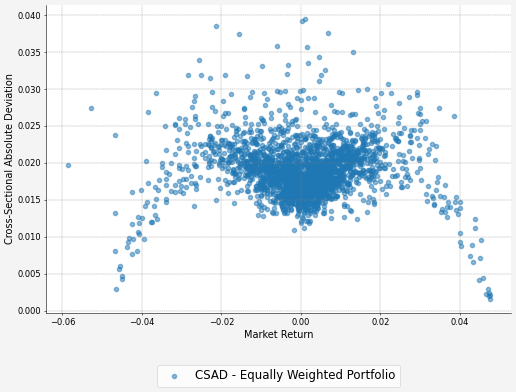

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.scatter(reg_table_use['Rm'], reg_table_use['CSAD'], color='#1f77b4', alpha=0.5, linewidth=2, label='CSAD - Equally Weighted Portfolio')

# Add labels and title
ax.set_xlabel('Market Return', fontsize=14)
ax.set_ylabel('Cross-Sectional Absolute Deviation', fontsize=14)

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.26), fontsize=17)
# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/CSAD_Rm_nocolor.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

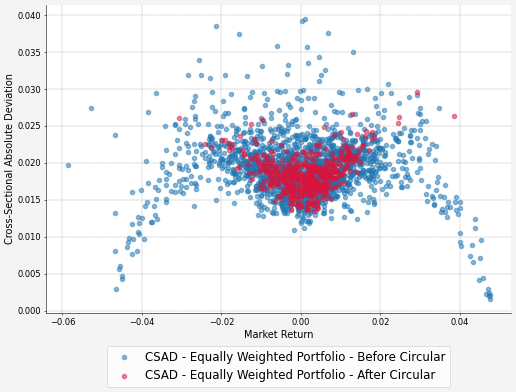

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.scatter(reg_table_use[reg_table_use['Date']<='2016-01-01']['Rm'], reg_table_use[reg_table_use['Date']<='2016-01-01']['CSAD'], color='#1f77b4', alpha=0.5, linewidth=2, label='CSAD - Equally Weighted Portfolio - Before Circular')
ax.scatter(reg_table_use[reg_table_use['Date']>'2016-01-01']['Rm'], reg_table_use[reg_table_use['Date']>'2016-01-01']['CSAD'], color='crimson', alpha=0.5, linewidth=2, label='CSAD - Equally Weighted Portfolio - After Circular')
# Add labels and title
ax.set_xlabel('Market Return', fontsize=14)
ax.set_ylabel('Cross-Sectional Absolute Deviation', fontsize=14)

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.26), fontsize=17)

# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/CSAD_Rm_color.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## 1.4 Chart for Data

In [ ]:
# Generate data
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
group1_values = [170, 595, 591, 454, 678, 842, 985, 1147, 1492, 2614, 2876 ]
group2_values = [55, 125, 131, 83, 86, 106, 136, 151, 151, 223, 192]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)

# Create the bar chart
ax.bar(years, group1_values, width=0.4, align='edge', label='HoSE', color = '#2B4F81')
ax.bar(years, group2_values, width=-0.4, align='edge', label='HNX', color = 'crimson')

# Add labels and title
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Market Capitalization', fontsize=14)

ax.set_title('Market capitalisation – Ho Chi Minh and Hanoi Stock Exchanges')

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.26), fontsize=17)

# Set the x-axis limits to be wider than the range of the data
ax.set_xlim(years[0]-1, years[-1]+1)

# Set the x-axis ticks
plt.xticks(years)

# Save
fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/Vonhoa.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## 1.5 Describe

In [ ]:
def describex(df):
  stats = df.describe()
  stats.loc['var'] = df.var().tolist()
  stats.loc['skew'] = df.skew().tolist()
  stats.loc['kurt'] = df.kurtosis().tolist()
  return stats

In [ ]:
describex(reg_table_use[['CSAD','Rm']])


,CSAD,Rm
count,2341.000000,2341.000000
mean,0.019033,0.000391
std,0.003777,0.013587
min,0.001587,-0.058717
25%,0.016812,-0.006073
50%,0.018773,0.000792
75%,0.020971,0.007518
max,0.039471,0.047629
var,0.000014,0.000185
skew,0.484632,-0.175790


In [ ]:
describex(reg_table_use_eq[['CSAD','Rm']])

,CSAD,Rm
count,2341.000000,2341.000000
mean,0.018442,0.000586
std,0.003508,0.012519
min,0.001616,-0.047659
25%,0.016436,-0.004957
50%,0.018178,0.001072
75%,0.020082,0.006501
max,0.038309,0.047305
var,0.000012,0.000157
skew,0.518696,-0.162297


In [ ]:
result_use = result[(result['Date']>='2008-08-18')&(result['Date']<'2018-01-01')]

In [ ]:
describex(result_use.daily_return[result_use['Rm']>0.02])

count    21282.000000
mean         0.023719
std          0.026289
min         -0.070000
25%          0.004264
50%          0.029406
75%          0.046397
max          0.070000
var          0.000691
skew        -0.866478
kurt         0.353669
Name: daily_return, dtype: float64

In [ ]:
describex(result_use.daily_return[result_use['Rm']<-0.02])

count    24870.000000
mean        -0.025060
std          0.027416
min         -0.070000
25%         -0.046950
50%         -0.033139
75%         -0.006578
max          0.070000
var          0.000752
skew         0.963520
kurt         0.521431
Name: daily_return, dtype: float64

# 3. Thực hiện hồi quy

## 3.5 Asymmetric information with herding

### 3.5.1 Herding Herding at the aggregate market level - Changing market information environment

In [ ]:
### Issuance of Circular 155/2015/TT-BTC by the Ministry of Finance, which requires companies to disclose information about their ownership structures and shareholders.
## Active day 2016-01-01
reg_table_event_1 = reg_table_use.copy()
reg_table_event_1['Da'] = reg_table_event_1['Date'] > '2016-01-01'
reg_table_event_1['Du'] = reg_table_event_1['Rm'] > 0
reg_table_event_1['Rm_Du'] = reg_table_event_1['Rm']*reg_table_event_1['Du']
reg_table_event_1['Rm_1-Du'] = reg_table_event_1['Rm']*(1-reg_table_event_1['Du'])
reg_table_event_1['Rm_Du_1-Da'] = reg_table_event_1['Rm']*reg_table_event_1['Du']*(1-reg_table_event_1['Da'])
reg_table_event_1['Rm_1-Du_1-Da'] = reg_table_event_1['Rm']*(1-reg_table_event_1['Du'])*(1-reg_table_event_1['Da'])
reg_table_event_1['Rm_Du_Da'] = reg_table_event_1['Rm']*reg_table_event_1['Du']*reg_table_event_1['Da']
reg_table_event_1['Rm_1-Du_Da'] = reg_table_event_1['Rm']*(1-reg_table_event_1['Du'])*reg_table_event_1['Da']
reg_table_event_1['Rm_sq_Du'] = reg_table_event_1['Rm_sq']*reg_table_event_1['Du']
reg_table_event_1['Rm_sq_1-Du'] = reg_table_event_1['Rm_sq']*(1-reg_table_event_1['Du'])
reg_table_event_1['Rm_sq_Du_1-Da'] = reg_table_event_1['Rm_sq']*reg_table_event_1['Du']*(1-reg_table_event_1['Da'])
reg_table_event_1['Rm_sq_1-Du_1-Da'] = reg_table_event_1['Rm_sq']*(1-reg_table_event_1['Du'])*(1-reg_table_event_1['Da'])
reg_table_event_1['Rm_sq_Du_Da'] = reg_table_event_1['Rm_sq']*reg_table_event_1['Du']*reg_table_event_1['Da']
reg_table_event_1['Rm_sq_1-Du_Da'] = reg_table_event_1['Rm_sq']*(1-reg_table_event_1['Du'])*reg_table_event_1['Da']
reg_table_event_1['CSAD-1'] = reg_table_event_1['CSAD'].shift(1)
reg_table_event_1.dropna(inplace = True)




In [ ]:
X = reg_table_event_1[['Rm_ab', 'Rm_sq']]
X = sm.add_constant(X)
Y = reg_table_event_1['CSAD']
ols_model = sm.OLS(Y,X)
ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   CSAD   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     102.6
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.92e-43
Time:                        12:11:15   Log-Likelihood:                 9995.7
No. Observations:                2340   AIC:                        -1.999e+04
Df Residuals:                    2337   BIC:                        -1.997e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0168      0.000     92.121      0.0

In [ ]:
variables = ['Rm_ab','Rm_sq','CSAD']
unit_root_test_df1 = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(reg_table_event_1[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test_df1 = pd.concat([unit_root_test_df1, new_row], ignore_index=True)

unit_root_test_df1

,Variables,Stat,p_value
0,Rm_ab,-5.735725,6.445323e-07
1,Rm_sq,-5.514662,1.937161e-06
2,CSAD,-6.251722,4.437370e-08


In [ ]:
X = reg_table_event_1[['Rm_Du', 'Rm_1-Du', 'Rm_sq_Du_1-Da', 'Rm_sq_1-Du_1-Da', 'Rm_sq_Du_Da','Rm_sq_1-Du_Da', 'CSAD-1']]
X = sm.add_constant(X)
Y = reg_table_event_1['CSAD']
ols_model = sm.OLS(Y,X)
ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   CSAD   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     98.45
Date:                Mon, 15 May 2023   Prob (F-statistic):          2.74e-126
Time:                        12:11:16   Log-Likelihood:                 10194.
No. Observations:                2340   AIC:                        -2.037e+04
Df Residuals:                    2332   BIC:                        -2.033e+04
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0107      0.001     

In [ ]:
X = reg_table_event_1[['Rm_Du', 'Rm_1-Du', 'Rm_sq_Du_1-Da', 'Rm_sq_1-Du_1-Da', 'Rm_sq_Du_Da','Rm_sq_1-Du_Da']]
X = sm.add_constant(X)
Y = reg_table_event_1['CSAD']
ols_model = sm.OLS(Y,X)
ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   CSAD   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     69.80
Date:                Mon, 15 May 2023   Prob (F-statistic):           3.69e-80
Time:                        12:11:16   Log-Likelihood:                 10018.
No. Observations:                2340   AIC:                        -2.002e+04
Df Residuals:                    2333   BIC:                        -1.998e+04
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0168      0.000    1

In [ ]:
ols_result.f_test('Rm_sq_Du_1-Da = Rm_sq_1-Du_1-Da')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=2.8979524986795373, p=0.08882536118273755, df_denom=2.33e+03, df_num=1>

### 3.5.2 Herding due to fundamental and nonfundamental information

In [ ]:
fama4data.head()

,Date,dinterest,RMRF,SMB,HML,smb,hml,LOSER,WINER,UMD
0,2008-07-01,0.000397,0.025166,-0.000044,-0.001187,-0.000609,-0.001942,0.028357,0.026980,-0.001377
1,2008-07-02,0.000527,0.023105,-0.000104,-0.004204,-0.002177,-0.002985,0.025178,0.020561,-0.004617
2,2008-07-03,0.000397,0.025265,-0.001538,0.002461,-0.001604,0.000955,0.026293,0.025086,-0.001207
3,2008-07-04,0.000397,0.021995,0.003246,0.003951,0.000928,0.000714,0.028033,0.015215,-0.012818
4,2008-07-07,0.000332,-0.008951,-0.011524,-0.018153,-0.002703,-0.010799,-0.015446,0.018155,0.033601


In [ ]:
Fama4factors_export = fama4data[(fama4data['Date']>='2008-08-18')&(fama4data['Date']<'2018-01-01')][['Date', 'dinterest', 'RMRF', 'SMB', 'HML', 'UMD']]
Fama4factors_export = Fama4factors_export[Fama4factors_export['UMD'].notnull()]
Fama4factors_export = Fama4factors_export.reset_index(drop=True)

In [ ]:
reg_table_with_fama = pd.merge(reg_table_use, fama4data[['Date','RMRF','SMB','HML','UMD']], on = ['Date'])
reg_table_with_fama = reg_table_with_fama[reg_table_with_fama['UMD'].notnull()]
reg_table_with_fama = reg_table_with_fama[(reg_table_with_fama['Date']<'2018-01-01')&(reg_table_with_fama['Date']>='2008-08-18')]

#################################################################################
X = abs(reg_table_with_fama[['RMRF', 'HML', 'SMB', 'UMD']])
X = sm.add_constant(X)
Y = reg_table_with_fama['CSAD']
ols_model = sm.OLS(Y,X)
ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

#################################################################################

reg_param = ols_result.params

reg_table_with_fama['CSAD_f'] = reg_param[0] + abs(reg_table_with_fama['RMRF'])*reg_param[1]+ abs(reg_table_with_fama['HML'])*reg_param[2] \
                                + abs(reg_table_with_fama['SMB'])*reg_param[3] + abs(reg_table_with_fama['UMD'])*reg_param[4]
reg_table_with_fama['CSAD_non'] = reg_table_with_fama['CSAD'] - reg_table_with_fama['CSAD_f']

                            OLS Regression Results                            
Dep. Variable:                   CSAD   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     122.4
Date:                Mon, 15 May 2023   Prob (F-statistic):           6.45e-95
Time:                        12:11:16   Log-Likelihood:                 10090.
No. Observations:                2335   AIC:                        -2.017e+04
Df Residuals:                    2330   BIC:                        -2.014e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0156      0.000     96.644      0.0

In [ ]:
reg_table_with_fama

,Date,Rm,CSAD,Rm_ab,Rm_sq,RMRF,SMB,HML,UMD,CSAD_f,CSAD_non
0,2008-08-18,0.039085,0.015367,0.039085,0.001528,0.038585,0.001358,-0.002933,0.036462,0.018233,-0.002866
1,2008-08-19,0.006850,0.037518,0.006850,0.000047,0.006350,-0.013574,-0.010928,0.041286,0.024833,0.012685
2,2008-08-20,-0.005982,0.035799,0.005982,0.000036,-0.006501,-0.013888,-0.009471,0.005111,0.021386,0.014412
3,2008-08-21,0.034437,0.018044,0.034437,0.001186,0.033909,-0.002337,-0.002086,-0.004426,0.015653,0.002390
4,2008-08-22,0.001901,0.033475,0.001901,0.000004,0.001422,0.000083,0.007507,0.036433,0.020128,0.013347
...,...,...,...,...,...,...,...,...,...,...,...
2336,2017-12-25,0.006290,0.020415,0.006290,0.000040,0.006160,-0.000836,-0.013037,0.016682,0.019252,0.001163
2337,2017-12-26,0.007951,0.020374,0.007951,0.000063,0.007821,-0.003157,-0.003861,0.002593,0.017082,0.003292
2338,2017-12-27,0.002619,0.015716,0.002619,0.000007,0.002489,0.001716,0.005378,0.003449,0.017208,-0.001492
2339,2017-12-28,0.008529,0.016755,0.008529,0.000073,0.008399,-0.006410,0.004165,0.008833,0.018619,-0.001863


In [ ]:
reg_table_with_fama['Du'] = reg_table_with_fama['Rm'] > 0
reg_table_with_fama['Da'] = reg_table_with_fama['Date'] > '2016-01-01'
reg_table_with_fama['CSAD_f-1'] = reg_table_with_fama['CSAD_f'].shift(1)
reg_table_with_fama['CSAD_non-1'] = reg_table_with_fama['CSAD_non'].shift(1)
reg_table_with_fama['CSAD_f+1'] = reg_table_with_fama['CSAD_f'].shift(-1)

#########################################################################
reg_table_with_fama_new = reg_table_with_fama.copy()
reg_table_with_fama_new['Rm_Du'] = reg_table_with_fama['Rm']*reg_table_with_fama['Du']
reg_table_with_fama_new['Rm_1-Du'] = reg_table_with_fama['Rm']*(1-reg_table_with_fama['Du'])
reg_table_with_fama_new['Rm_Du_1-Da'] = reg_table_with_fama_new['Rm']*reg_table_with_fama_new['Du']*(1-reg_table_with_fama_new['Da'])
reg_table_with_fama_new['Rm_1-Du_1-Da'] = reg_table_with_fama_new['Rm']*(1-reg_table_with_fama_new['Du'])*(1-reg_table_with_fama_new['Da'])
reg_table_with_fama_new['Rm_Du_Da'] = reg_table_with_fama_new['Rm']*reg_table_with_fama_new['Du']*reg_table_with_fama_new['Da']
reg_table_with_fama_new['Rm_1-Du_Da'] = reg_table_with_fama_new['Rm']*(1-reg_table_with_fama_new['Du'])*reg_table_with_fama_new['Da']
reg_table_with_fama_new['Rm_sq_1-Du'] = reg_table_with_fama['Rm_sq']*(1-reg_table_with_fama['Du'])
reg_table_with_fama_new['Rm_sq_Du'] = reg_table_with_fama['Rm_sq']*reg_table_with_fama['Du']
reg_table_with_fama_new['Rm_sq_Du_1-Da'] = reg_table_with_fama['Rm_sq']*reg_table_with_fama['Du']*(1-reg_table_with_fama['Da'])
reg_table_with_fama_new['Rm_sq_1-Du_1-Da'] = reg_table_with_fama['Rm_sq']*(1-reg_table_with_fama['Du'])*(1-reg_table_with_fama['Da'])
reg_table_with_fama_new['Rm_sq_Du_Da'] = reg_table_with_fama['Rm_sq']*reg_table_with_fama['Du']*reg_table_with_fama['Da']
reg_table_with_fama_new['Rm_sq_1-Du_Da'] = reg_table_with_fama['Rm_sq']*(1-reg_table_with_fama['Du'])*reg_table_with_fama['Da']
reg_table_with_fama_new.dropna(inplace = True)


In [ ]:
variables = ['RMRF', 'HML', 'SMB', 'UMD','Rm_Du', 'Rm_1-Du', 'Rm_sq_Du_1-Da', 'Rm_sq_1-Du_1-Da', 'Rm_sq_Du_Da','Rm_sq_1-Du_Da', 'CSAD_non','CSAD_f']
unit_root_test_df2 = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(reg_table_with_fama_new[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test_df2 = pd.concat([unit_root_test_df2, new_row], ignore_index=True)

unit_root_test_df2

,Variables,Stat,p_value
0,RMRF,-39.551844,0.000000e+00
1,HML,-16.654370,1.593933e-29
2,SMB,-13.434634,3.951842e-25
3,UMD,-41.413762,0.000000e+00
4,Rm_Du,-6.277248,3.873487e-08
5,Rm_1-Du,-8.583824,7.601553e-14
6,Rm_sq_Du_1-Da,-5.023295,1.995393e-05
7,Rm_sq_1-Du_1-Da,-7.113290,3.888715e-10
8,Rm_sq_Du_Da,-5.072854,1.589227e-05
9,Rm_sq_1-Du_Da,-6.023368,1.475562e-07


In [ ]:
X = reg_table_with_fama_new[['Rm_Du', 'Rm_1-Du', 'Rm_sq_Du_1-Da', 'Rm_sq_1-Du_1-Da', 'Rm_sq_Du_Da','Rm_sq_1-Du_Da', 'CSAD_non-1']]
X = sm.add_constant(X)
Y = reg_table_with_fama_new['CSAD_non']
ols_model = sm.OLS(Y,X)
ols_result_non = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result_non.summary())

                            OLS Regression Results                            
Dep. Variable:               CSAD_non   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     104.2
Date:                Mon, 15 May 2023   Prob (F-statistic):          7.35e-133
Time:                        12:11:17   Log-Likelihood:                 10455.
No. Observations:                2333   AIC:                        -2.089e+04
Df Residuals:                    2325   BIC:                        -2.085e+04
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0016      0.000    -

In [ ]:
ols_result_non.f_test('Rm_sq_1-Du_1-Da = Rm_sq_1-Du_Da')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=12.611865479542193, p=0.000390924714378225, df_denom=2.32e+03, df_num=1>

In [ ]:
X = reg_table_with_fama_new[['Rm_Du', 'Rm_1-Du', 'Rm_sq_Du_1-Da', 'Rm_sq_1-Du_1-Da', 'Rm_sq_Du_Da','Rm_sq_1-Du_Da', 'CSAD_f-1']]
X = sm.add_constant(X)
Y = reg_table_with_fama_new['CSAD_f']
ols_model = sm.OLS(Y,X)
ols_result_fu = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result_fu.summary())

                            OLS Regression Results                            
Dep. Variable:                 CSAD_f   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     15.74
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.70e-20
Time:                        12:11:17   Log-Likelihood:                 11278.
No. Observations:                2333   AIC:                        -2.254e+04
Df Residuals:                    2325   BIC:                        -2.249e+04
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0158      0.000     

### 3.5.3 Herding at the investor level


In [ ]:
result['Date']

0        2000-07-31
1        2000-07-31
2        2000-08-02
3        2000-08-02
4        2000-08-04
            ...    
985062   2023-01-27
985063   2023-01-27
985064   2023-01-27
985065   2023-01-27
985066   2023-01-27
Name: Date, Length: 985067, dtype: datetime64[ns]

In [ ]:
## TAO BANG DATAFRAME ABNORMAL RETURN VA P-VALUE CUA NO

def getting_alpha(daily_return, X):
  X = sm.add_constant(X)
  Y = daily_return
  ols_model = sm.OLS(Y,X)
  ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
  return ols_result.params[0] > 0 , ols_result.pvalues[0]

result['year'] = result['Date'].dt.year

reg_investor_table = pd.merge(result, fama4data[['Date','RMRF','SMB','HML','UMD']], on = ['Date'])
reg_investor_table = reg_investor_table[reg_investor_table['UMD'].notnull()]
reg_investor_table = reg_investor_table[(reg_investor_table['Date']>='2008-08-18')&(reg_investor_table['Date']<'2018-01-01')]

checkk = (reg_investor_table.groupby(['Ticker','year']).size() >= 40).to_frame().rename(columns = {0: 'Check'})
reg_investor_table = pd.merge(reg_investor_table, checkk, on = ['Ticker', 'year'])
reg_investor_table = reg_investor_table[reg_investor_table['Check']]
reg_investor_table.drop('Check', axis = 1, inplace = True)

alpha0po_df = reg_investor_table.groupby(['Ticker','year']).apply(lambda x: getting_alpha(x['daily_return'], x[['RMRF', 'SMB', 'HML', 'UMD']])).to_frame()
alpha0po_df.rename(columns = {0: 'alpha0_positiveandpvl'}, inplace = True)
alpha0po_df['alpha0_positive'] = alpha0po_df['alpha0_positiveandpvl'].apply(lambda x: x[0])
alpha0po_df['p-value'] = alpha0po_df['alpha0_positiveandpvl'].apply(lambda x: x[1])
alpha0po_df.drop('alpha0_positiveandpvl', axis = 1, inplace = True)

reg_investor_table_1 = pd.merge(reg_investor_table, alpha0po_df, on = ['Ticker', 'year'])
reg_investor_table_1.drop(['Rm'], axis = 1, inplace = True )
reg_investor_table_1.sort_values(['Ticker', 'Date'], inplace = True)
reg_investor_table_1.dropna(inplace = True)

# Loc stock theo p-value
reg_investor_table_1 = reg_investor_table_1[reg_investor_table_1['p-value']<=0.1]

In [ ]:
# TAO BANG DU LIEU HOAN CHINH CHO ARBITRAGEURS VA NOISE TRADERS

Return_mwithpn = reg_investor_table_1.groupby(['Date','alpha0_positive']).apply(lambda x: x['daily_return'].mean()).to_frame()
Return_mwithpn.rename(columns = {0: 'Rm_withalpha0'}, inplace = True )
Return_mwithpn.reset_index(inplace = True)

Return_mwithpn_to_merge = Return_mwithpn[Return_mwithpn['alpha0_positive']].rename(columns = {'Rm_withalpha0': 'Rm_withalpha0_positive'}).reset_index(drop = True)
Return_mwithpn_to_merge['Rm_withalpha0_negative'] = Return_mwithpn[~Return_mwithpn['alpha0_positive']]['Rm_withalpha0'].reset_index(drop = True)
Return_mwithpn_to_merge.drop('alpha0_positive', axis = 1, inplace = True)

reg_investor_table_final = pd.merge(reg_investor_table_1, Return_mwithpn, on = ['Date', 'alpha0_positive'])

rm_positive = Return_mwithpn[Return_mwithpn['alpha0_positive']].rename(columns = {'Rm_withalpha0': 'Rm_withalpha0_positive'}).drop('alpha0_positive', axis = 1)
rm_negative = Return_mwithpn[Return_mwithpn['alpha0_positive'] == False].rename(columns = {'Rm_withalpha0': 'Rm_withalpha0_negative'}).drop('alpha0_positive', axis = 1)

abcd = reg_investor_table_final.groupby(by = ['Date','alpha0_positive']).apply(lambda x: \
                                    (abs((x['daily_return'] - x['Rm_withalpha0'])).mean())).to_frame().rename(columns = {0: 'CSAD_on_alpha'})
abcd.reset_index(inplace = True)

abcd_positive = abcd[abcd['alpha0_positive']].rename(columns = {'CSAD_on_alpha': 'CSAD_on_alpha_positive'}).drop('alpha0_positive', axis = 1)
abcd_negative = abcd[abcd['alpha0_positive'] == False].rename(columns = {'CSAD_on_alpha': 'CSAD_on_alpha_negative'}).drop('alpha0_positive', axis = 1)
abcd_total = pd.merge(abcd_positive, abcd_negative, on = ['Date'])
abcd_total = pd.merge(abcd_total, rm_positive, on = ['Date'])
abcd_total = pd.merge(abcd_total, rm_negative, on = ['Date'])
abcd_total['Rm_withalpha0_positive_abs'] = abs(abcd_total['Rm_withalpha0_positive'])
abcd_total['Rm_withalpha0_negative_abs'] = abs(abcd_total['Rm_withalpha0_negative'])
abcd_total['Rm_withalpha0_positive_sq'] = abcd_total['Rm_withalpha0_positive']**2
abcd_total['Rm_withalpha0_negative_sq'] = abcd_total['Rm_withalpha0_negative']**2

abcd_total['Da'] = (abcd_total['Date'] > '2016-01-01').astype(int)

abcd_total['Rm_withalpha0_positive_sq_Da'] = abcd_total['Rm_withalpha0_positive']*abcd_total['Da']
abcd_total['Rm_withalpha0_negative_sq_Da'] = abcd_total['Rm_withalpha0_negative']*abcd_total['Da']
abcd_total['Rm_withalpha0_positive_abs_Da'] = abcd_total['Rm_withalpha0_positive_abs']*abcd_total['Da']
abcd_total['Rm_withalpha0_negative_abs_Da'] = abcd_total['Rm_withalpha0_negative_abs']*abcd_total['Da']
abcd_total['Rm_withalpha0_positive_Da'] = abcd_total['Rm_withalpha0_positive']*abcd_total['Da']
abcd_total['Rm_withalpha0_negative_Da'] = abcd_total['Rm_withalpha0_negative']*abcd_total['Da']



In [ ]:
variables = ['CSAD_on_alpha_positive', 'Rm_withalpha0_positive','Rm_withalpha0_positive_abs', 'Rm_withalpha0_positive_sq','Rm_withalpha0_positive_sq_Da']
unit_root_test_df3 = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(abcd_total[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test_df3 = pd.concat([unit_root_test_df3, new_row], ignore_index=True)

unit_root_test_df3

,Variables,Stat,p_value
0,CSAD_on_alpha_positive,-7.155722,3.058478e-10
1,Rm_withalpha0_positive,-9.887434,3.632490e-17
2,Rm_withalpha0_positive_abs,-4.896725,3.538989e-05
3,Rm_withalpha0_positive_sq,-5.546812,1.653741e-06
4,Rm_withalpha0_positive_sq_Da,-3.565177,6.462750e-03


In [ ]:
variables = ['Rm_withalpha0_positive','Rm_withalpha0_positive_abs', 'Rm_withalpha0_positive_sq', 'Rm_withalpha0_negative_sq', 'CSAD_on_alpha_negative', 'CSAD_on_alpha_positive' ]
unit_root_test_df3 = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(abcd_total[(abcd_total['Date']>'2016-01-01')&(abcd_total['Date']>'2008-08-18')][variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test_df3 = pd.concat([unit_root_test_df3, new_row], ignore_index=True)

unit_root_test_df3

,Variables,Stat,p_value
0,Rm_withalpha0_positive,-11.123177,3.425341e-20
1,Rm_withalpha0_positive_abs,-18.684056,2.041113e-30
2,Rm_withalpha0_positive_sq,-19.717609,0.000000e+00
3,Rm_withalpha0_negative_sq,-4.557683,1.544671e-04
4,CSAD_on_alpha_negative,-3.572514,6.308770e-03
5,CSAD_on_alpha_positive,-8.292326,4.228971e-13


In [ ]:
variables = ['Rm_withalpha0_negative','Rm_withalpha0_negative_abs', 'Rm_withalpha0_negative_sq', 'Rm_withalpha0_positive_sq', 'CSAD_on_alpha_positive', 'CSAD_on_alpha_negative' ]
unit_root_test_df3 = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(abcd_total[(abcd_total['Date']>'2016-01-01')&(abcd_total['Date']>'2008-08-18')][variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test_df3 = pd.concat([unit_root_test_df3, new_row], ignore_index=True)

unit_root_test_df3

,Variables,Stat,p_value
0,Rm_withalpha0_negative,-18.825760,2.022139e-30
1,Rm_withalpha0_negative_abs,-4.375987,3.272654e-04
2,Rm_withalpha0_negative_sq,-4.557683,1.544671e-04
3,Rm_withalpha0_positive_sq,-19.717609,0.000000e+00
4,CSAD_on_alpha_positive,-8.292326,4.228971e-13
5,CSAD_on_alpha_negative,-3.572514,6.308770e-03


In [ ]:
X = abcd_total[['Rm_withalpha0_positive','Rm_withalpha0_positive_abs', 'Rm_withalpha0_positive_sq','Rm_withalpha0_positive_sq_Da']]
X = sm.add_constant(X)
Y = abcd_total['CSAD_on_alpha_positive']
ols_model1 = sm.OLS(Y,X)
ols_result = ols_model1.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

                              OLS Regression Results                              
Dep. Variable:     CSAD_on_alpha_positive   R-squared:                       0.161
Model:                                OLS   Adj. R-squared:                  0.159
Method:                     Least Squares   F-statistic:                     141.3
Date:                    Mon, 15 May 2023   Prob (F-statistic):          5.11e-108
Time:                            12:11:32   Log-Likelihood:                 8994.9
No. Observations:                    2287   AIC:                        -1.798e+04
Df Residuals:                        2282   BIC:                        -1.795e+04
Df Model:                               4                                         
Covariance Type:                      HAC                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

In [ ]:
X = abcd_total[(abcd_total['Date']<='2016-01-01')&(abcd_total['Date']>='2008-08-18')][['Rm_withalpha0_positive','Rm_withalpha0_positive_abs', 'Rm_withalpha0_positive_sq', 'Rm_withalpha0_negative_sq', 'CSAD_on_alpha_negative']]
X = sm.add_constant(X)
Y = abcd_total[(abcd_total['Date']<='2016-01-01')&(abcd_total['Date']>='2008-08-18')]['CSAD_on_alpha_positive']
ols_model1 = sm.OLS(Y,X)
ols_result = ols_model1.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

print('.'*50)
X = abcd_total[(abcd_total['Date']>'2016-01-01')&(abcd_total['Date']<'2018-01-01')][['Rm_withalpha0_positive','Rm_withalpha0_positive_abs', 'Rm_withalpha0_positive_sq', 'Rm_withalpha0_negative_sq', 'CSAD_on_alpha_negative']]
X = sm.add_constant(X)
Y = abcd_total[(abcd_total['Date']>'2016-01-01')&(abcd_total['Date']<'2018-01-01')]['CSAD_on_alpha_positive']
ols_model2 = sm.OLS(Y,X)
ols_result = ols_model2.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

                              OLS Regression Results                              
Dep. Variable:     CSAD_on_alpha_positive   R-squared:                       0.190
Model:                                OLS   Adj. R-squared:                  0.188
Method:                     Least Squares   F-statistic:                     97.77
Date:                    Mon, 15 May 2023   Prob (F-statistic):           3.13e-91
Time:                            12:11:32   Log-Likelihood:                 6998.0
No. Observations:                    1788   AIC:                        -1.398e+04
Df Residuals:                        1782   BIC:                        -1.395e+04
Df Model:                               5                                         
Covariance Type:                      HAC                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [ ]:
X = abcd_total[(abcd_total['Date']<='2016-01-01')&(abcd_total['Date']>='2008-08-18')][['Rm_withalpha0_negative','Rm_withalpha0_negative_abs', 'Rm_withalpha0_negative_sq', 'Rm_withalpha0_positive_sq', 'CSAD_on_alpha_positive']]
X = sm.add_constant(X)
Y = abcd_total[(abcd_total['Date']<='2016-01-01')&(abcd_total['Date']>='2008-08-18')]['CSAD_on_alpha_negative']
ols_model = sm.OLS(Y,X)
ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

print('.'*100)
X = abcd_total[(abcd_total['Date']>'2016-01-01')&(abcd_total['Date']<'2018-01-01')][['Rm_withalpha0_negative','Rm_withalpha0_negative_abs', 'Rm_withalpha0_negative_sq', 'Rm_withalpha0_positive_sq', 'CSAD_on_alpha_positive']]
X = sm.add_constant(X)
Y = abcd_total[(abcd_total['Date']>'2016-01-01')&(abcd_total['Date']<'2018-01-01')]['CSAD_on_alpha_negative']
ols_model = sm.OLS(Y,X)
ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

                              OLS Regression Results                              
Dep. Variable:     CSAD_on_alpha_negative   R-squared:                       0.078
Model:                                OLS   Adj. R-squared:                  0.075
Method:                     Least Squares   F-statistic:                     33.34
Date:                    Mon, 15 May 2023   Prob (F-statistic):           1.26e-32
Time:                            12:11:32   Log-Likelihood:                 6148.5
No. Observations:                    1788   AIC:                        -1.228e+04
Df Residuals:                        1782   BIC:                        -1.225e+04
Df Model:                               5                                         
Covariance Type:                      HAC                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

# addition

## Herding at fundamental and nonfund with Rm equally weighted

In [ ]:
reg_table_with_fama = pd.merge(reg_table_eq, fama4data[['Date','RMRF','SMB','HML','UMD']], on = ['Date'])
reg_table_with_fama = reg_table_with_fama[reg_table_with_fama['UMD'].notnull()]
reg_table_with_fama = reg_table_with_fama[(reg_table_with_fama['Date']<'2018-01-01')&(reg_table_with_fama['Date']>='2008-08-18')]

#################################################################################
X = abs(reg_table_with_fama[['RMRF', 'HML', 'SMB', 'UMD']])
X = sm.add_constant(X)
Y = reg_table_with_fama['CSAD']
ols_model = sm.OLS(Y,X)
ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result.summary())

#################################################################################

reg_param = ols_result.params

reg_table_with_fama['CSAD_f'] = reg_param[0] + abs(reg_table_with_fama['RMRF'])*reg_param[1]+ abs(reg_table_with_fama['HML'])*reg_param[2] \
                                + abs(reg_table_with_fama['SMB'])*reg_param[3] + abs(reg_table_with_fama['UMD'])*reg_param[4]
reg_table_with_fama['CSAD_non'] = reg_table_with_fama['CSAD'] - reg_table_with_fama['CSAD_f']

                            OLS Regression Results                            
Dep. Variable:                   CSAD   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     79.65
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.02e-63
Time:                        12:11:32   Log-Likelihood:                 10187.
No. Observations:                2335   AIC:                        -2.036e+04
Df Residuals:                    2330   BIC:                        -2.034e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0157      0.000     94.765      0.0

In [ ]:
reg_table_with_fama['Du'] = reg_table_with_fama['Rm'] > 0
reg_table_with_fama['Da'] = reg_table_with_fama['Date'] > '2016-01-01'
reg_table_with_fama['CSAD_f-1'] = reg_table_with_fama['CSAD_f'].shift(1)
reg_table_with_fama['CSAD_non-1'] = reg_table_with_fama['CSAD_non'].shift(1)

#########################################################################
reg_table_with_fama_new = reg_table_with_fama.copy()
reg_table_with_fama_new['Rm_Du'] = reg_table_with_fama['Rm']*reg_table_with_fama['Du']
reg_table_with_fama_new['Rm_1-Du'] = reg_table_with_fama['Rm']*(1-reg_table_with_fama['Du'])
reg_table_with_fama_new['Rm_Du_1-Da'] = reg_table_with_fama_new['Rm']*reg_table_with_fama_new['Du']*(1-reg_table_with_fama_new['Da'])
reg_table_with_fama_new['Rm_1-Du_1-Da'] = reg_table_with_fama_new['Rm']*(1-reg_table_with_fama_new['Du'])*(1-reg_table_with_fama_new['Da'])
reg_table_with_fama_new['Rm_Du_Da'] = reg_table_with_fama_new['Rm']*reg_table_with_fama_new['Du']*reg_table_with_fama_new['Da']
reg_table_with_fama_new['Rm_1-Du_Da'] = reg_table_with_fama_new['Rm']*(1-reg_table_with_fama_new['Du'])*reg_table_with_fama_new['Da']
reg_table_with_fama_new['Rm_sq_1-Du'] = reg_table_with_fama['Rm_sq']*(1-reg_table_with_fama['Du'])
reg_table_with_fama_new['Rm_sq_Du'] = reg_table_with_fama['Rm_sq']*reg_table_with_fama['Du']
reg_table_with_fama_new['Rm_sq_Du_1-Da'] = reg_table_with_fama['Rm_sq']*reg_table_with_fama['Du']*(1-reg_table_with_fama['Da'])
reg_table_with_fama_new['Rm_sq_1-Du_1-Da'] = reg_table_with_fama['Rm_sq']*(1-reg_table_with_fama['Du'])*(1-reg_table_with_fama['Da'])
reg_table_with_fama_new['Rm_sq_Du_Da'] = reg_table_with_fama['Rm_sq']*reg_table_with_fama['Du']*reg_table_with_fama['Da']
reg_table_with_fama_new['Rm_sq_1-Du_Da'] = reg_table_with_fama['Rm_sq']*(1-reg_table_with_fama['Du'])*reg_table_with_fama['Da']
reg_table_with_fama_new.dropna(inplace = True)


In [ ]:
variables = ['CSAD','RMRF', 'HML', 'SMB', 'UMD','Rm_Du', 'Rm_1-Du', 'Rm_sq_Du_1-Da', 'Rm_sq_1-Du_1-Da', 'Rm_sq_Du_Da','Rm_sq_1-Du_Da', 'CSAD_non','CSAD_f']
unit_root_test_df4 = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(reg_table_with_fama_new[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test_df4 = pd.concat([unit_root_test_df4, new_row], ignore_index=True)

unit_root_test_df4

,Variables,Stat,p_value
0,CSAD,-7.989734,2.493071e-12
1,RMRF,-39.556391,0.000000e+00
2,HML,-16.660381,1.576017e-29
3,SMB,-13.435621,3.935154e-25
4,UMD,-41.427314,0.000000e+00
5,Rm_Du,-5.760142,5.697427e-07
6,Rm_1-Du,-5.793503,4.811143e-07
7,Rm_sq_Du_1-Da,-5.018242,2.042032e-05
8,Rm_sq_1-Du_1-Da,-6.215230,5.386053e-08
9,Rm_sq_Du_Da,-4.738973,7.105484e-05


In [ ]:
X = reg_table_with_fama_new[['Rm_Du', 'Rm_1-Du', 'Rm_sq_Du_1-Da', 'Rm_sq_1-Du_1-Da', 'Rm_sq_Du_Da','Rm_sq_1-Du_Da', 'CSAD_non-1']]
X = sm.add_constant(X)
Y = reg_table_with_fama_new['CSAD_non']
ols_model = sm.OLS(Y,X)
ols_result_non = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result_non.summary())

                            OLS Regression Results                            
Dep. Variable:               CSAD_non   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     148.6
Date:                Mon, 15 May 2023   Prob (F-statistic):          1.54e-181
Time:                        12:11:33   Log-Likelihood:                 10670.
No. Observations:                2334   AIC:                        -2.132e+04
Df Residuals:                    2326   BIC:                        -2.128e+04
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0016   9.71e-05    -

In [ ]:
ols_result_non.f_test('Rm_sq_1-Du_1-Da = Rm_sq_1-Du_Da')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=6.288022573837482, p=0.012223294804304131, df_denom=2.33e+03, df_num=1>

In [ ]:
X = reg_table_with_fama_new[['Rm_Du', 'Rm_1-Du', 'Rm_sq_Du_1-Da', 'Rm_sq_1-Du_1-Da', 'Rm_sq_Du_Da','Rm_sq_1-Du_Da', 'CSAD_f-1']]
X = sm.add_constant(X)
Y = reg_table_with_fama_new['CSAD_f']
ols_model = sm.OLS(Y,X)
ols_result_fu = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(ols_result_fu.summary())

                            OLS Regression Results                            
Dep. Variable:                 CSAD_f   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     27.88
Date:                Mon, 15 May 2023   Prob (F-statistic):           4.83e-37
Time:                        12:11:33   Log-Likelihood:                 11718.
No. Observations:                2334   AIC:                        -2.342e+04
Df Residuals:                    2326   BIC:                        -2.337e+04
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0157      0.000     

In [ ]:
ols_result_fu.f_test('Rm_sq_Du_1-Da = Rm_sq_Du_Da')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.8108408580005882, p=0.3679649862831479, df_denom=2.33e+03, df_num=1>

## Firm-level of information

In [ ]:
finproraw = pd.read_excel('/content/gdrive/MyDrive/[DATA-NCKH]/Fiinpro - Non-financial firms 2007-2018_du lieu goc (1).xlsx', sheet_name = 'Sheet4' )
Cap = pd.read_stata('/content/gdrive/MyDrive/[NCKH-HERDING-K60CLC4] /DATA/weeklyreturntil22.dta')

capitalization = Cap.sort_values(['ticker', 'newdate']).set_index('newdate').groupby('ticker').resample('Y').last().drop('ticker', axis = 1).reset_index()
capitalization['year'] = capitalization.newdate.dt.year
capitalization = capitalization[['ticker', 'year', 'marketcap']].rename(columns = {'ticker': 'Ticker'})
capitalization['marketcap'] = capitalization['marketcap'] * (10**6)

intangible = pd.read_excel('/content/gdrive/MyDrive/[NCKH-HERDING-K60CLC4] /DATA/Intangible.xlsx')
intangible = intangible[intangible.Exchg == 'HOSE'].drop('Exchg', axis = 1)

equity =  finproraw[finproraw['exchg'] == 'HOSE'][['ticker', 'year', 'equity']].rename(columns = {'ticker': 'Ticker'})

Ownership = pd.read_stata('/content/gdrive/MyDrive/[NCKH-HERDING-K60CLC4] /DATA/ownership.dta')
owner = Ownership.rename(columns = {'symbol': 'Ticker'})[['Ticker', 'year', 'own_ins_st']].dropna().drop_duplicates()

In [ ]:
Firm_file = pd.merge(capitalization, equity, on =  ['Ticker', 'year'])
Firm_file = pd.merge(Firm_file, intangible, on =  ['Ticker', 'year'])
# Firm_file = pd.merge(Firm_file, owner, how = 'left', on =  ['Ticker', 'year'])
Firm_file['P/B'] = Firm_file['marketcap']/(Firm_file['equity'])

In [ ]:
Firm_file.drop_duplicates(subset=['Ticker', 'year'], inplace= True)

In [ ]:
Firm_file.describe()

,year,marketcap,equity,Intangible,P/B
count,2926.000000,2.759000e+03,2.926000e+03,2.926000e+03,2759.000000
mean,2013.393028,3.383330e+12,1.543023e+12,6.351674e+10,1.384392
std,3.275186,1.646854e+13,4.271707e+12,3.094601e+11,1.521293
min,2007.000000,1.872094e+10,1.094438e+09,0.000000e+00,0.083607
25%,2011.000000,1.984976e+11,2.202860e+11,2.281103e+08,0.615459
50%,2014.000000,5.075969e+11,4.762938e+11,7.443606e+09,1.011689
75%,2016.000000,1.422931e+12,1.144577e+12,3.464828e+10,1.594838
max,2018.000000,3.252262e+14,9.901371e+13,7.001665e+12,35.707862


In [ ]:
result_export['year'] = result_export.Date.dt.year

In [ ]:
def generate_regdataset(df):
  ### create regtable:
  lll = df.groupby('Date').apply(lambda x: x['daily_return'].mean()).to_frame()
  lll.rename(columns = {0: 'Rm'}, inplace = True)
  df = pd.merge(lll, df, on = ['Date'])
  reg_table = df.groupby(by = 'Date').apply(lambda x: (abs((x['daily_return'] - x['Rm'])).mean())).to_frame().rename(columns = {0: 'CSAD'})
  reg_table = pd.merge(lll, reg_table, on = ['Date'])
  reg_table['Rm_ab'] = abs(reg_table['Rm'])
  reg_table['Rm_sq'] = reg_table['Rm']**2
  return reg_table

def tile_reg(df, a):
  ### Create 2 tertile subdatasets
  df['tile'] = pd.qcut(df[a], 6, labels=False)
  tile_low = df[df['tile'] == 0]
  tile_high = df[df['tile'] == 5]

  reg_table_low = generate_regdataset(tile_low).reset_index(drop = True)
  reg_table_high = generate_regdataset(tile_high).reset_index(drop = True)

  #################################################################################
  X = reg_table_low[['Rm_ab', 'Rm_sq']]
  X = sm.add_constant(X)
  Y = reg_table_low['CSAD']
  ols_model_low = sm.OLS(Y,X)
  ols_result_low = ols_model_low.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
  print(ols_result_low.summary())
  #################################################################################
  X = reg_table_high[['Rm_ab', 'Rm_sq']]
  X = sm.add_constant(X)
  Y = reg_table_high['CSAD']
  ols_model_high = sm.OLS(Y,X)
  ols_result_high = ols_model_high.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
  print(ols_result_high.summary())
  #################################################################################

  # Concatenate the datasets vertically
  reg_table = pd.concat([reg_table_low, reg_table_high], ignore_index=True)

  # Create a binary dummy column to indicate the source dataset
  reg_table['Du'] = reg_table.index > len(reg_table_low)

  # Convert the boolean values to 0s and 1s
  reg_table['Du'] = reg_table['Du'].astype(int)
  reg_table['Rm_ab_cor'] = reg_table['Rm_ab']*reg_table['Du']
  reg_table['Rm_sq_cor'] = reg_table['Rm_sq']*reg_table['Du']
  #################################################################################
  X = reg_table[['Du','Rm_ab', 'Rm_sq', 'Rm_ab_cor', 'Rm_sq_cor']]
  X = sm.add_constant(X)
  Y = reg_table['CSAD']
  ols_model = sm.OLS(Y,X)
  ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})

  print(ols_result.f_test('Rm_sq_cor = 0'))

  #######################################################################################
  return reg_table_low, reg_table_high

### Market cap + P/B

In [ ]:
result_for_reg_firm = pd.merge(Firm_file[['Ticker', 'year', 'marketcap', 'P/B']], result_export, on = ['Ticker', 'year'])

In [ ]:
result_for_reg_firm

,Ticker,year,marketcap,P/B,Date,daily_return
0,AAA,2016,1.193700e+12,1.250272,2016-11-28,-0.016721
1,AAA,2016,1.193700e+12,1.250272,2016-11-29,0.000000
2,AAA,2016,1.193700e+12,1.250272,2016-11-30,0.000000
3,AAA,2016,1.193700e+12,1.250272,2016-12-01,-0.040818
4,AAA,2016,1.193700e+12,1.250272,2016-12-02,0.000000
...,...,...,...,...,...,...
449042,VTO,2017,6.979700e+11,0.615407,2017-12-25,0.069935
449043,VTO,2017,6.979700e+11,0.615407,2017-12-26,-0.001148
449044,VTO,2017,6.979700e+11,0.615407,2017-12-27,0.016068
449045,VTO,2017,6.979700e+11,0.615407,2017-12-28,-0.011290


In [ ]:
cap_low, cap_high = tile_reg(result_for_reg_firm, 'marketcap')

                            OLS Regression Results                            
Dep. Variable:                   CSAD   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     632.0
Date:                Mon, 15 May 2023   Prob (F-statistic):          3.70e-220
Time:                        12:13:47   Log-Likelihood:                 9023.0
No. Observations:                2341   AIC:                        -1.804e+04
Df Residuals:                    2338   BIC:                        -1.802e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0219      0.000     99.708      0.0

In [ ]:
###############################################################################
variables = ['Rm_ab','Rm_sq','CSAD']
unit_root_test = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(cap_low[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test = pd.concat([unit_root_test, new_row], ignore_index=True)

print(unit_root_test)

  Variables      Stat       p_value
0     Rm_ab -5.809344  4.438986e-07
1     Rm_sq -4.984732  2.379019e-05
2      CSAD -4.228831  5.886443e-04


In [ ]:
###############################################################################
variables = ['Rm_ab','Rm_sq','CSAD']
unit_root_test = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(cap_high[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test = pd.concat([unit_root_test, new_row], ignore_index=True)

print(unit_root_test)

  Variables      Stat       p_value
0     Rm_ab -5.315123  5.094203e-06
1     Rm_sq -5.644885  1.016697e-06
2      CSAD -7.885654  4.577350e-12


### Kurtosis

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

checkk = (result_export.groupby(['Ticker','year']).size() >= 40).to_frame().rename(columns = {0: 'Check'})
result_export_1 = pd.merge(result_export, checkk, on = ['Ticker', 'year'])
result_export_1 = result_export_1[result_export_1['Check']]
result_export_1.drop('Check', axis = 1, inplace = True)

ama = result_export_1.groupby(['Ticker', 'year']).apply(pd.DataFrame.kurt).rename(columns = {'daily_return': 'Kur'}).drop('year', axis = 1)
result_export_kur = pd.merge(result_export_1, ama, on = ['Ticker', 'year'])
result_export_kur

,Ticker,Date,daily_return,year,Kur
0,AAA,2017-01-03,0.051289,2017,1.557113
1,AAA,2017-01-04,0.012195,2017,1.557113
2,AAA,2017-01-05,0.020078,2017,1.557113
3,AAA,2017-01-06,-0.035433,2017,1.557113
4,AAA,2017-01-09,0.061224,2017,1.557113
...,...,...,...,...,...
500319,VTO,2017-12-25,0.069935,2017,7.131064
500320,VTO,2017-12-26,-0.001148,2017,7.131064
500321,VTO,2017-12-27,0.016068,2017,7.131064
500322,VTO,2017-12-28,-0.011290,2017,7.131064


In [ ]:
result_export_kur

,Ticker,Date,daily_return,year,Kur,tile
0,AAA,2017-01-03,0.051289,2017,1.557113,4
1,AAA,2017-01-04,0.012195,2017,1.557113,4
2,AAA,2017-01-05,0.020078,2017,1.557113,4
3,AAA,2017-01-06,-0.035433,2017,1.557113,4
4,AAA,2017-01-09,0.061224,2017,1.557113,4
...,...,...,...,...,...,...
500319,VTO,2017-12-25,0.069935,2017,7.131064,5
500320,VTO,2017-12-26,-0.001148,2017,7.131064,5
500321,VTO,2017-12-27,0.016068,2017,7.131064,5
500322,VTO,2017-12-28,-0.011290,2017,7.131064,5


In [ ]:
kur_low, kur_high = tile_reg(result_export_kur, 'Kur')

                            OLS Regression Results                            
Dep. Variable:                   CSAD   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     198.9
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.63e-80
Time:                        12:13:54   Log-Likelihood:                 7731.0
No. Observations:                2341   AIC:                        -1.546e+04
Df Residuals:                    2338   BIC:                        -1.544e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.000     66.654      0.0

In [ ]:
###############################################################################
variables = ['Rm_ab','Rm_sq','CSAD']
unit_root_test = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(kur_low[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test = pd.concat([unit_root_test, new_row], ignore_index=True)

print(unit_root_test)

  Variables      Stat       p_value
0     Rm_ab -6.147851  7.689423e-08
1     Rm_sq -5.718557  7.027779e-07
2      CSAD -2.192111  2.091211e-01


In [ ]:
###############################################################################
variables = ['Rm_ab','Rm_sq','CSAD']
unit_root_test = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(kur_high[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test = pd.concat([unit_root_test, new_row], ignore_index=True)

print(unit_root_test)

  Variables      Stat       p_value
0     Rm_ab -7.996903  2.390749e-12
1     Rm_sq -8.955778  8.482258e-15
2      CSAD -5.583569  1.379060e-06


### Idiosyncratic Risk

In [ ]:
def getting_alpha(daily_return, X):
  X = sm.add_constant(X)
  Y = daily_return
  ols_model = sm.OLS(Y,X)
  ols_result = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
  return ols_result.rsquared

result_export['year'] = result_export['Date'].dt.year

reg_firm_table = pd.merge(result_export, fama4data[['Date', 'dinterest','RMRF']], on = ['Date'])

checkk = (reg_firm_table.groupby(['Ticker','year']).size() >= 40).to_frame().rename(columns = {0: 'Check'})
reg_firm_table = pd.merge(reg_firm_table, checkk, on = ['Ticker', 'year'])
reg_firm_table = reg_firm_table[reg_firm_table['Check']]
reg_firm_table.drop('Check', axis = 1, inplace = True)

alpha0po_df = reg_firm_table.groupby(['Ticker','year']).apply(lambda x: getting_alpha(x['daily_return'], x[['dinterest', 'RMRF']])).to_frame()
alpha0po_df.rename(columns = {0: 'Rsquared'}, inplace = True)

reg_firm_table_1 = pd.merge(reg_firm_table, alpha0po_df, on = ['Ticker', 'year'])
reg_firm_table_1.sort_values(['Ticker', 'Date'], inplace = True)
reg_firm_table_1.dropna(inplace = True)

reg_firm_table_1['risk'] = 1 - reg_firm_table_1['Rsquared']
reg_firm_idisrisk = reg_firm_table_1[['Ticker', 'Date', 'daily_return', 'risk']]

In [ ]:
reg_firm_idisrisk

,Ticker,Date,daily_return,risk,tile
63840,AAA,2017-01-03,0.051289,0.919024,3
63841,AAA,2017-01-04,0.012195,0.919024,3
63842,AAA,2017-01-05,0.020078,0.919024,3
63843,AAA,2017-01-06,-0.035433,0.919024,3
63844,AAA,2017-01-09,0.061224,0.919024,3
...,...,...,...,...,...
124869,VTO,2017-12-25,0.069935,0.959869,4
124870,VTO,2017-12-26,-0.001148,0.959869,4
124871,VTO,2017-12-27,0.016068,0.959869,4
124872,VTO,2017-12-28,-0.011290,0.959869,4


In [ ]:
idio_low, idio_high = tile_reg(reg_firm_idisrisk, 'risk')

<ipython-input-98-13c0acfed065>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tile'] = pd.qcut(df[a], 6, labels=False)


                            OLS Regression Results                            
Dep. Variable:                   CSAD   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     112.8
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.64e-47
Time:                        12:14:05   Log-Likelihood:                 8785.4
No. Observations:                2341   AIC:                        -1.756e+04
Df Residuals:                    2338   BIC:                        -1.755e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.000     35.451      0.0

In [ ]:
###############################################################################
variables = ['Rm_ab','Rm_sq','CSAD']
unit_root_test = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(idio_low[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test = pd.concat([unit_root_test, new_row], ignore_index=True)

print(unit_root_test)

  Variables      Stat       p_value
0     Rm_ab -6.753547  2.910022e-09
1     Rm_sq -7.117092  3.806008e-10
2      CSAD -4.652196  1.033876e-04


In [ ]:
###############################################################################
variables = ['Rm_ab','Rm_sq','CSAD']
unit_root_test = pd.DataFrame({
    'Variables': [],
    'Stat': [],
    'p_value': []
})

for variable in variables:
  result_unit = adfuller(idio_high[variable])
  new_row = pd.DataFrame({'Variables': [variable], 'Stat': [result_unit[0]], 'p_value': [result_unit[1]]})
  unit_root_test = pd.concat([unit_root_test, new_row], ignore_index=True)

print(unit_root_test)

  Variables      Stat   p_value
0     Rm_ab -4.465929  0.000226
1     Rm_sq -5.145489  0.000011
2      CSAD -3.960968  0.001629


# Export data

In [ ]:
Export_data =




# Chart for firm-level

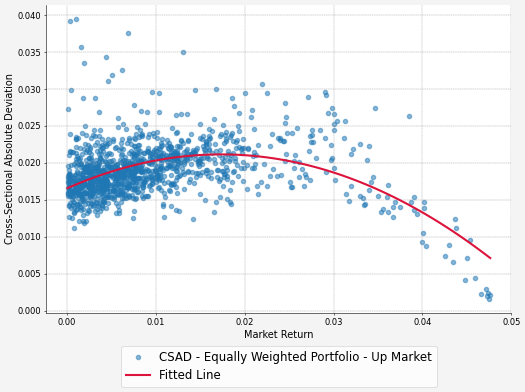

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.scatter(reg_table_use[reg_table_use['Rm']>0]['Rm'], reg_table_use[reg_table_use['Rm']>0]['CSAD'], color='#1f77b4', alpha=0.5, linewidth=2, label='CSAD - Equally Weighted Portfolio - Up Market')

# Add labels and title
ax.set_xlabel('Market Return', fontsize=14)
ax.set_ylabel('Cross-Sectional Absolute Deviation', fontsize=14)

# Fit a quadratic regression model to the data
coeffs = np.polyfit(reg_table_use[reg_table_use['Rm']>0]['Rm'], reg_table_use[reg_table_use['Rm']>0]['CSAD'], 2)
quad_fit = np.poly1d(coeffs)


# Add the quadratic regression line to the plot
x_range = np.linspace(reg_table_use[reg_table_use['Rm']>0]['Rm'].min(), reg_table_use[reg_table_use['Rm']>0]['Rm'].max(), 100)
ax.plot(x_range, quad_fit(x_range), color='crimson', linewidth=3, label='Fitted Line')

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/CSAD_Rm_Up.png', dpi=300, bbox_inches='tight')

# Add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.26), fontsize=17)

# Show the plot
plt.show()

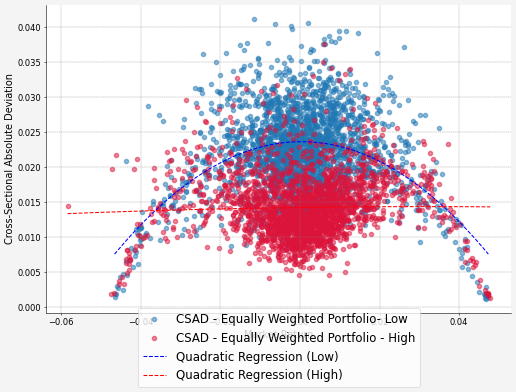

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=50)
ax.scatter(cap_low['Rm'], cap_low['CSAD'], color='#1f77b4', alpha=0.5, linewidth=2, label='CSAD - Equally Weighted Portfolio- Low')
ax.scatter(cap_high['Rm'], cap_high['CSAD'], color='crimson', alpha=0.5, linewidth=2, label='CSAD - Equally Weighted Portfolio - High')

# Add quadratic regression lines for cap_low
x_low = cap_low['Rm']
y_low = cap_low['CSAD']
coeffs_low = np.polyfit(x_low, y_low, 2) # Fit quadratic regression
x_low_quad = np.linspace(min(x_low), max(x_low), 100) # Generate x values for regression line
y_low_quad = np.polyval(coeffs_low, x_low_quad) # Calculate y values for regression line
ax.plot(x_low_quad, y_low_quad, color='blue', linestyle='--', label='Quadratic Regression (Low)')

# Add quadratic regression lines for cap_high
x_high = cap_high['Rm']
y_high = cap_high['CSAD']
coeffs_high = np.polyfit(x_high, y_high, 2) # Fit quadratic regression
x_high_quad = np.linspace(min(x_high), max(x_high), 100) # Generate x values for regression line
y_high_quad = np.polyval(coeffs_high, x_high_quad) # Calculate y values for regression line
ax.plot(x_high_quad, y_high_quad, color='red', linestyle='--', label='Quadratic Regression (High)')

# Add labels and title
ax.set_xlabel('Market Return', fontsize=14)
ax.set_ylabel('Cross-Sectional Absolute Deviation', fontsize=14)

# Customize the axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set the background color
fig.set_facecolor('#F4F4F4')

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.26), fontsize=17)

# Save
# fig.savefig('/content/gdrive/MyDrive/[NCKH-K60CLC4] /File Chart/CSAD_Rm_color.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()